In [1]:
import numpy as np
import emcee
from scipy.optimize import minimize
import math
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
data = pd.read_csv('M_sigma.csv').values

# x is log velocity dispersion (sigma)
x = np.array(data[::,0], dtype = np.float64)
x_err = data[::,1]

# y is log mass BH
y = np.array(data[::,2], dtype = np.float64)
y_err = data[::,3]


numpy.ndarray

In [3]:
#Using log likelihood because it's easier and I kept getting errors when using non-log likelihood
def likelihood (theta, x, y, yerr):
    theta1, theta0 = theta
    model = theta1*x +theta0
    sig2 = np.array(yerr**2, dtype=np.float64)
    
    return -0.5 * np.sum((y - model) ** 2 / sig2 + np.log(sig2))
    #return math.prod(1/np.sqrt(2*np.pi*sig2)*np.exp(-(y-(model))**2/(2*sig2)))

#Using the log prior
def prior(theta):
    return 0

#Full (log) probability function
def p_function(theta, x, y, yerr):
    return prior(theta) + likelihood(theta, x, y, yerr)

In [35]:
OLS_slope = 5.5289
OLS_inter = np.mean(y) - OLS_slope*np.mean(x)
OLS_err = 0.0649

n_chains = 10
n_dim = 2

t1 = OLS_slope+np.random.randn(n_chains)*0.1
t0 = OLS_inter+np.random.randn(n_chains)*0.1

init = np.array([t1,t0]).T

sampler = emcee.EnsembleSampler(n_chains, n_dim, p_function, args=(x, y, y_err))
sampler.run_mcmc(init, 2000, progress=True)
samples = sampler.get_chain()

100%|██████████| 2000/2000 [00:00<00:00, 2631.92it/s]


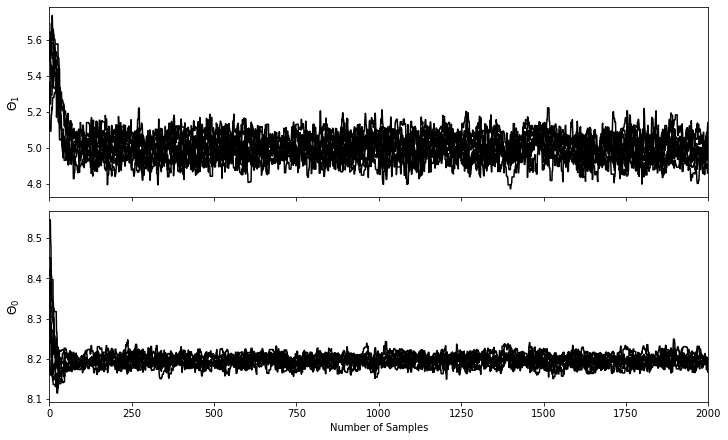

In [37]:
fig, axes = plt.subplots(2, figsize=(10, 6), sharex=True, constrained_layout = True)

ax1 = axes[0]
ax1.plot(samples[:, :, 0], "k")
ax1.set_xlim(0, len(samples))
ax1.set_ylabel("$\Theta_1$", fontsize =12)

ax2 = axes[1]
ax2.plot(samples[:, :, 1], "k")
ax2.set_xlim(0, len(samples))
ax2.set_ylabel("$\Theta_0$", fontsize = 12)
ax2.set_xlabel("Number of Samples")

plt.savefig('HW2_trace_plot.png')

In [21]:
keep_samples = sampler.get_chain(discard=200, flat=True)
theta1_samples = keep_samples[:,0]
theta0_samples = keep_samples[:,1]

t1_sample_mean = np.mean(theta1_samples)
t1_sample_median = np.median(theta1_samples)
t1_95_cred = np.percentile(theta1_samples, 97.5)-np.percentile(theta1_samples, 2.5)

t0_sample_mean = np.mean(theta0_samples)
t0_sample_median = np.median(theta0_samples)
t0_95_cred = np.percentile(theta0_samples, 97.5)-np.percentile(theta0_samples, 2.5)

In [22]:
print("Theta_1 sample mean: ", round(t1_sample_mean,5))
print("Theta_1 sample median: ", round(t1_sample_median,5))
print("Theta_1 95% credible interval: ±", round(t1_95_cred,5))
print("")
print("Theta_0 sample mean: ", round(t0_sample_mean,5))
print("Theta_0 sample median: ", round(t0_sample_median,5))
print("Theta_0 95% credible interval: ±", round(t0_95_cred,5))

Theta_1 sample mean:  5.00528
Theta_1 sample median:  5.00612
Theta_1 95% credible interval: ± 0.26712

Theta_0 sample mean:  8.19442
Theta_0 sample median:  8.19438
Theta_0 95% credible interval: ± 0.05258


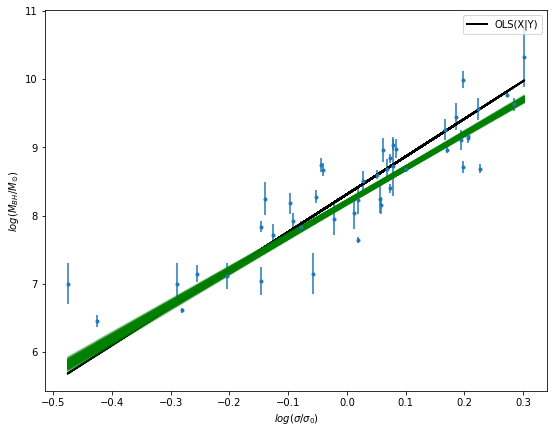

In [38]:
plt.figure(figsize = (9,7))
plt.errorbar(x, y, yerr = y_err, marker = '.', linestyle='')
plt.plot(x, OLS_slope*x + OLS_inter, "k", lw=2, label="OLS(X|Y)")

rando = np.random.randint(len(keep_samples), size=500)
for i in rando:
    sample = keep_samples[i]
    plt.plot(x, x*sample[0]+sample[1], "green", alpha=0.1)
plt.legend()
plt.xlabel('$log(\sigma/\sigma_0)$')
plt.ylabel('$log(M_{BH}/M_{\odot})$')
plt.savefig('linear.png')

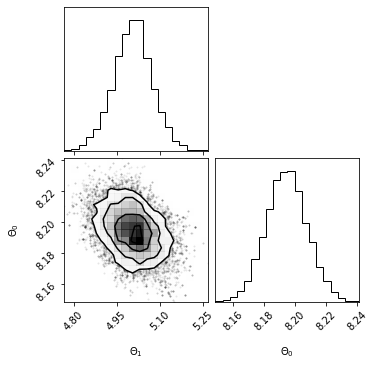

In [39]:
import corner

figure = corner.corner(keep_samples, labels=["$\Theta_1$", "$\Theta_0$"])
plt.savefig('corner_plot.png')